In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader

from diffdrr import DRR, load_example_ct
from diffdrr.metrics import XCorr2
from diffdrr.visualization import plot_drr

from loss import GenLoss

tensor([3.1416, 0.0000, 1.5708], device='cuda:0')
tensor([180.0000, 180.0000, 166.2500], device='cuda:0', dtype=torch.float64)


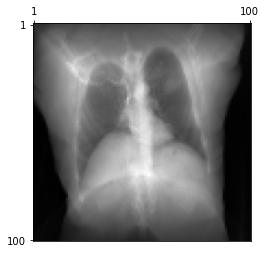

In [2]:
# Read in the volume
volume, spacing = load_example_ct()

# Get the true parameters for the detector
sdr = 200.0
true_rotations = torch.tensor([torch.pi, 0, torch.pi / 2]).cuda()
true_translations = (torch.tensor(volume.shape) * torch.tensor(spacing) / 2).cuda()

# Make the DRR
drr = DRR(volume, spacing, height=100, delx=5e-2, device="cuda")
img = drr.project(sdr, true_rotations, true_translations)

# Look at the ground truth
print(true_rotations)
print(true_translations)
plot_drr(img)
plt.show()

In [3]:
class Model(nn.Module):
    def __init__(self, rotation=False, dtype=torch.float32, device="cuda"):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, 5, dtype=dtype, device=device)
        self.conv2 = torch.nn.Conv2d(6, 16, 5, dtype=dtype, device=device)
        self.pool = torch.nn.MaxPool2d(2)
        self.norm1 = torch.nn.BatchNorm2d(6, dtype=dtype, device=device)
        self.norm2 = torch.nn.BatchNorm2d(16, dtype=dtype, device=device)
        self.fc1 = torch.nn.Linear(16 * 22 * 22, 120, dtype=dtype, device=device)
        self.fc2 = torch.nn.Linear(120, 84, dtype=dtype, device=device)
        self.fc3 = torch.nn.Linear(84, 3, dtype=dtype, device=device)
        self.rotation = rotation

    def forward(self, x):
        x = x.view(-1, 1, 100, 100)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.norm1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.norm2(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        if self.rotation:
            x = torch.remainder(x, 2 * torch.pi)
        return x

    def num_flat_features(self, x):
        return torch.tensor(x.shape[1:]).prod().item()

In [4]:
class GenLoss(nn.Module):
    def __init__(self, drr, sdr=200.0, zero_mean_normalized=True):
        super(GenLoss, self).__init__()
        self.drr = drr
        self.sdr = sdr
        self.xcorr2 = XCorr2(zero_mean_normalized)

    def forward(self, est_rotations, est_translations, true_rotations, true_translations):
        est_drr = self.drr.project(self.sdr, est_rotations[0], est_translations[0])
        true_drr = self.drr.project(self.sdr, true_rotations, true_translations)
        loss = -self.xcorr2(true_drr, est_drr)
        return loss, est_drr, true_drr

In [5]:
# Initialize loss and model
model_rotations = Model(rotation=True)
model_rotations.train(True)
model_translations = Model()
model_translations.train(True)

opt_rotations = optim.SGD(model_rotations.parameters(), lr=3e-3)
opt_translations = optim.SGD(model_translations.parameters(), lr=3e-1)
loss_func = GenLoss(drr)

Epoch 0: 0.14273585379123688
tensor([[6.2573, 6.1358, 6.1096]]) tensor([[0.0866, 0.0412, 0.0997]])


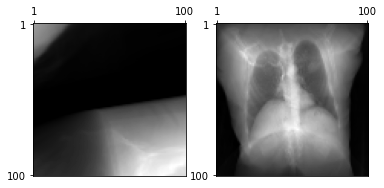

Epoch 100: -0.20419110357761383
tensor([[0.7790, 4.0541, 1.0083]]) tensor([[0.6729, 0.2364, 0.1628]])


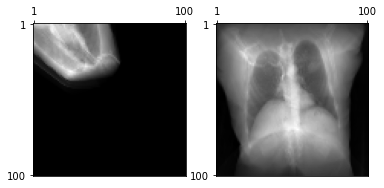

Epoch 200: -0.17422455549240112
tensor([[0.5424, 3.8850, 1.4888]]) tensor([[2.2403, 0.7997, 0.7840]])


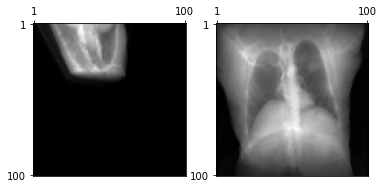

Epoch 300: -0.4840567111968994
tensor([[0.8646, 1.9868, 1.7640]]) tensor([[10.9740, 11.3744, 14.0880]])


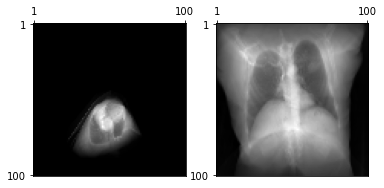

Epoch 400: -0.5581780076026917
tensor([[1.0002, 2.2012, 1.8129]]) tensor([[ 67.5489,  69.2346, 108.7045]])


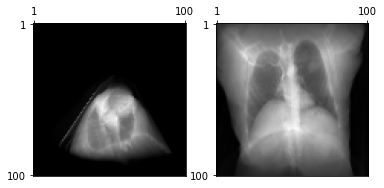

Epoch 500: -0.5652639269828796
tensor([[0.9956, 2.2446, 1.8206]]) tensor([[ 87.3934,  66.0282, 113.7904]])


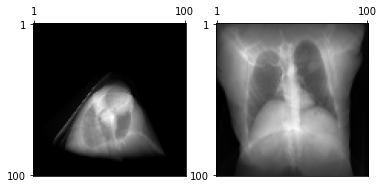

Epoch 600: -0.5518368482589722
tensor([[0.9274, 2.1868, 1.7339]]) tensor([[ 94.1440,  60.6702, 122.0940]])


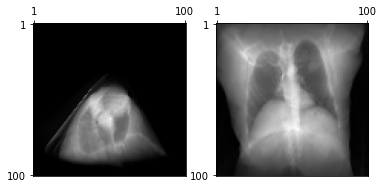

Epoch 700: -0.5322311520576477
tensor([[0.9727, 2.1271, 1.8454]]) tensor([[ 94.9611,  64.0367, 122.5283]])


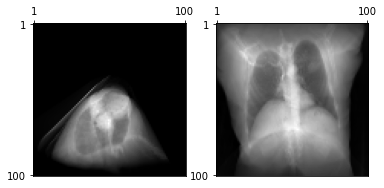

Epoch 800: -0.5490882992744446
tensor([[1.0056, 2.3543, 1.7850]]) tensor([[ 81.4223,  60.3486, 107.1167]])


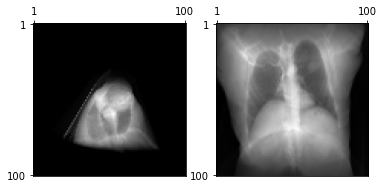

Epoch 900: -0.5612480044364929
tensor([[0.9833, 2.1948, 1.8037]]) tensor([[ 89.1989,  67.4461, 120.0631]])


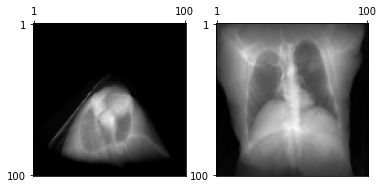

Epoch 1000: -0.5499480366706848
tensor([[0.9900, 2.1377, 1.8654]]) tensor([[ 86.8017,  65.7158, 119.1771]])


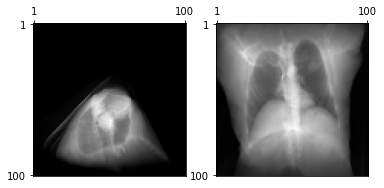

Epoch 1100: -0.5602302551269531
tensor([[0.9398, 2.1986, 1.8243]]) tensor([[ 84.5997,  67.5771, 118.5399]])


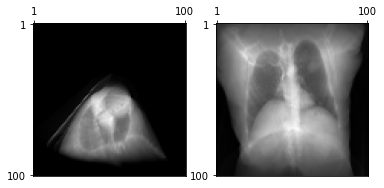

Epoch 1200: -0.552501916885376
tensor([[0.9626, 2.1482, 1.8543]]) tensor([[ 83.9191,  66.8134, 118.6721]])


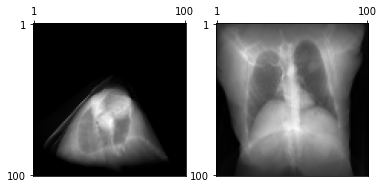

Epoch 1300: -0.5579902529716492
tensor([[0.9510, 2.1528, 1.8110]]) tensor([[ 83.9321,  65.5611, 116.8026]])


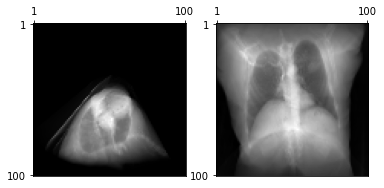

Epoch 1400: -0.5595316290855408
tensor([[0.9371, 2.1832, 1.8222]]) tensor([[ 83.2452,  64.4505, 115.9100]])


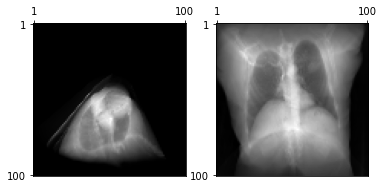

Epoch 1500: -0.5472161769866943
tensor([[0.9160, 2.3612, 1.7688]]) tensor([[ 78.2724,  61.3091, 106.2120]])


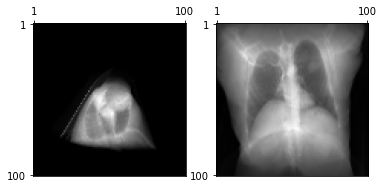

Epoch 1600: -0.508959174156189
tensor([[0.9758, 2.4724, 1.7263]]) tensor([[72.6022, 61.1034, 99.4251]])


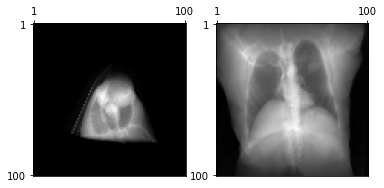

Epoch 1700: -0.5333112478256226
tensor([[0.9261, 2.4196, 1.7399]]) tensor([[ 75.7140,  62.3225, 103.6073]])


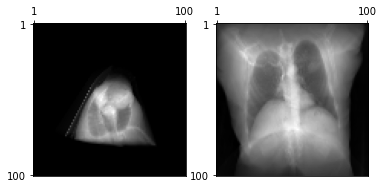

Epoch 1800: -0.5653584003448486
tensor([[0.9870, 2.1784, 1.8401]]) tensor([[ 77.9513,  66.9829, 113.5331]])


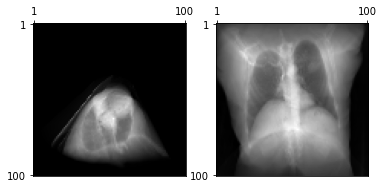

Epoch 1900: -0.5516769886016846
tensor([[0.9321, 2.1313, 1.8520]]) tensor([[ 78.7819,  68.4300, 116.3638]])


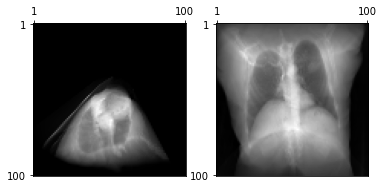

In [6]:
for epoch in range(2_000):
    # Zero the gradient for each batch
    opt_rotations.zero_grad()
    opt_translations.zero_grad()

    # Make predictions of the batch
    est_rotations = model_rotations(img)
    est_translations = model_translations(img)

    # Compute loss and its gradient
    loss, est_drr, true_drr = loss_func(est_rotations, est_translations, true_rotations, true_translations)
    loss.backward(retain_graph=True)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}:", loss.item())
        print(est_rotations.detach().cpu(), est_translations.detach().cpu())
        fig, axs = plt.subplots(ncols=2)
        plot_drr(est_drr, ax=axs[0])
        plot_drr(true_drr, ax=axs[1])
        plt.show()

    # Adjust the weights in an alternating fashion
    # if epoch % 2 == 0:
        # opt_rotations.step()
    # else:
        # opt_translations.step()
    opt_rotations.step()
    opt_translations.step()